In [1]:
# import the required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx
import warnings
warnings.filterwarnings("ignore")


In [2]:
# read the csv doc, preparing to analyze
data_file = 'AB_NYC_2019.csv'
data = pd.read_csv(data_file)


# step 1: data review

In [3]:
data_info = data.info()
print(data_info)
print(data.head())

# checking for missing data value
missing_value = data.isnull().sum()
print("缺失值情况：\n", missing_value)

# view basic statistics for data field
basic_statistics = data.describe()
print("基本统计信息：\n", basic_statistics)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

# step2: data cleaning and processing

In [4]:
# handling missing data
data['reviews_per_month'].fillna(0, inplace=True)

# handling outlier
data = data[data['price'] > 0]
data = data[data['minimum_nights'] <= 100]

# print data info after processing
print("清洗后数据的统计信息：\n", data.describe())


清洗后数据的统计信息：
                  id       host_id      latitude     longitude         price  \
count  4.871000e+04  4.871000e+04  48710.000000  48710.000000  48710.000000   
mean   1.902923e+07  6.768092e+07     40.728926    -73.952116    152.337323   
std    1.097921e+07  7.863728e+07      0.054537      0.046189    237.261250   
min    2.539000e+03  2.438000e+03     40.499790    -74.244420     10.000000   
25%    9.477162e+06  7.835312e+06     40.690060    -73.983030     69.000000   
50%    1.969462e+07  3.085086e+07     40.723040    -73.955660    106.000000   
75%    2.915608e+07  1.074344e+08     40.763130    -73.936170    175.000000   
max    3.648724e+07  2.743213e+08     40.913060    -73.712990  10000.000000   

       minimum_nights  number_of_reviews  reviews_per_month  \
count    48710.000000       48710.000000       48710.000000   
mean         6.155471          23.317430           1.093890   
std         10.049833          44.573394           1.598814   
min          1.000000  

# step3: analysis of neighbourhood_group and reviews

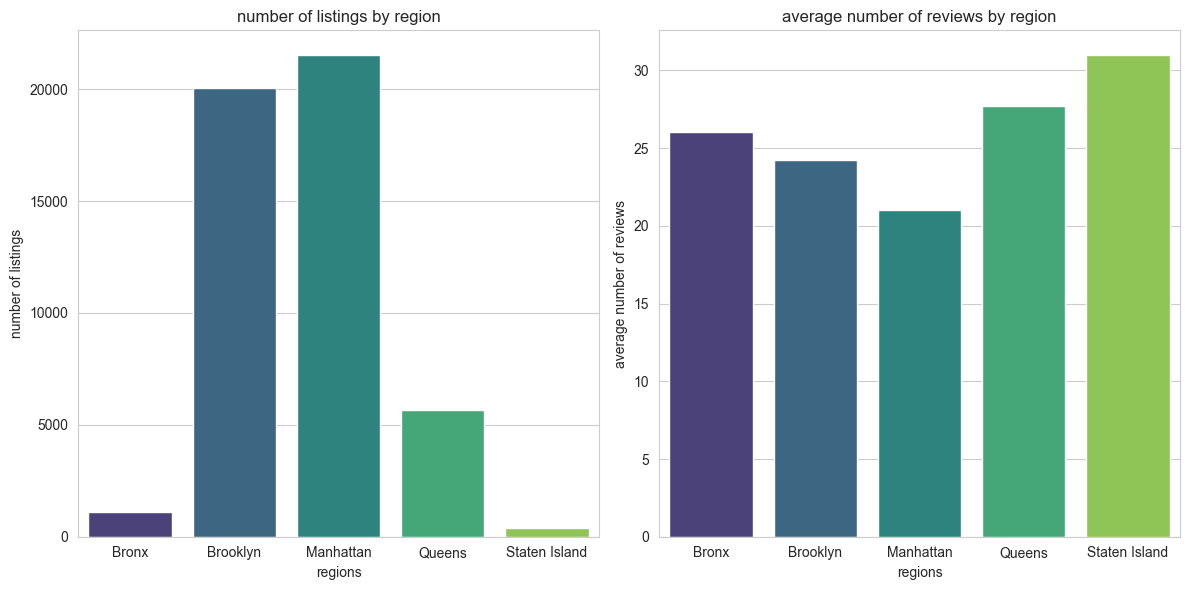

In [5]:
# calculate the number of listings and the average of reviews for each region
grouped_data = data.groupby('neighbourhood_group').agg(
    listings_count=('id', 'count'),
    average_reviews=('number_of_reviews', 'mean')
).reset_index()

# visualization of the number of listings in each region
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x='neighbourhood_group', y='listings_count', data=grouped_data, palette="viridis")
plt.title('number of listings by region')
plt.xlabel('regions')
plt.ylabel('number of listings')

plt.subplot(1, 2, 2)
sns.barplot(x='neighbourhood_group', y='average_reviews', data=grouped_data, palette="viridis")
plt.title('average number of reviews by region')
plt.xlabel('regions')
plt.ylabel('average number of reviews')

plt.tight_layout()
plt.show()


# step 4: Geographical distribution of areas with dense traffic

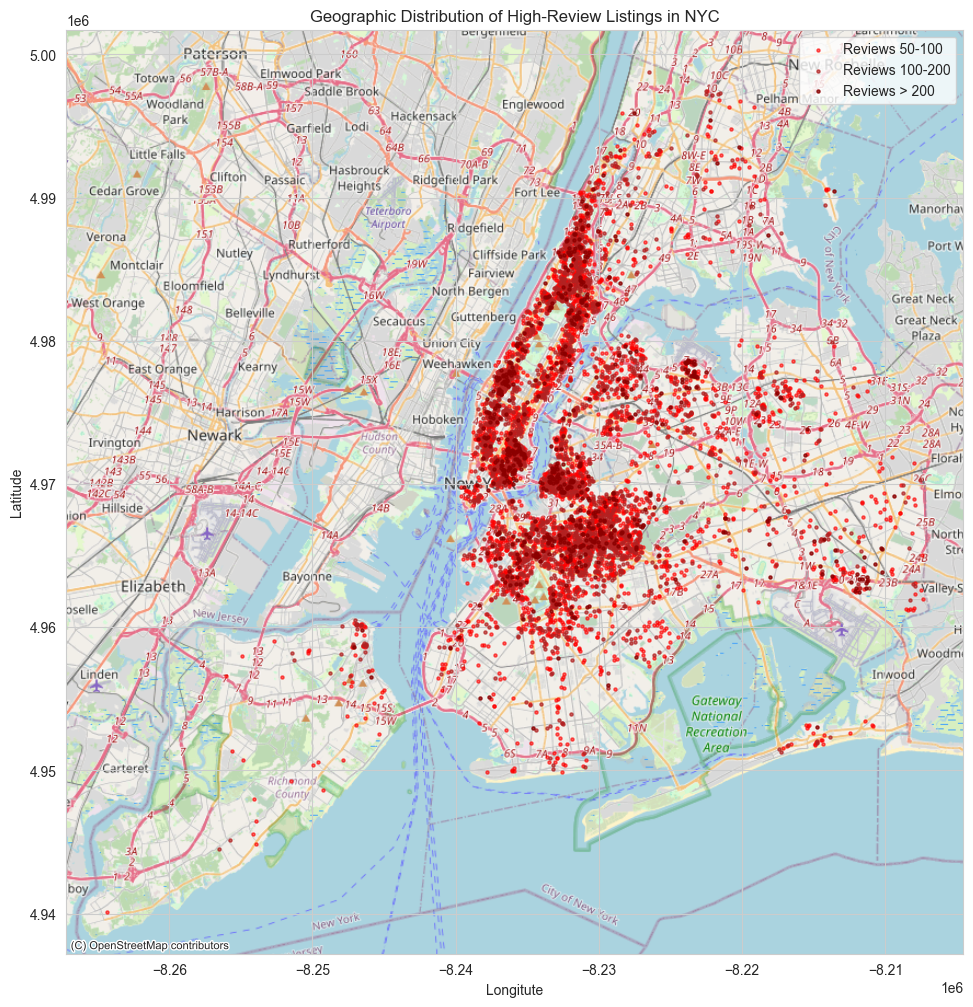

In [6]:
# select 3 levels of data
low_traffic = data[(data['number_of_reviews'] > 50) & (data['number_of_reviews'] <= 100)]
mid_traffic = data[(data['number_of_reviews'] > 100) & (data['number_of_reviews'] <= 200)]
high_traffic = data[data['number_of_reviews'] > 200]

# convert the dif levels data into geo data frames
low_geo_data = gpd.GeoDataFrame(low_traffic, geometry=[Point(xy) for xy in zip(low_traffic['longitude'], low_traffic['latitude'])], crs="EPSG:4326")
mid_geo_data = gpd.GeoDataFrame(mid_traffic, geometry=[Point(xy) for xy in zip(mid_traffic['longitude'], mid_traffic['latitude'])], crs="EPSG:4326")
high_geo_data = gpd.GeoDataFrame(high_traffic, geometry=[Point(xy) for xy in zip(high_traffic['longitude'], high_traffic['latitude'])], crs="EPSG:4326")

# convert to the Web Mercator coordinate system
low_geo_data = low_geo_data.to_crs(epsg=3857)
mid_geo_data = mid_geo_data.to_crs(epsg=3857)
high_geo_data = high_geo_data.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(12, 12))
low_geo_data.plot(ax=ax, markersize=5, color='red', alpha=0.6, label="Reviews 50-100")
mid_geo_data.plot(ax=ax, markersize=5, color='firebrick', alpha=0.7, label="Reviews 100-200")
high_geo_data.plot(ax=ax, markersize=5, color='darkred', alpha=0.8, label="Reviews > 200")
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_title("Geographic Distribution of High-Review Listings in NYC")
plt.xlabel("Longitute")
plt.ylabel("Latitude")
plt.legend()
plt.show()


# step 5: flow difference analysis: room type, price and minimum length of stay

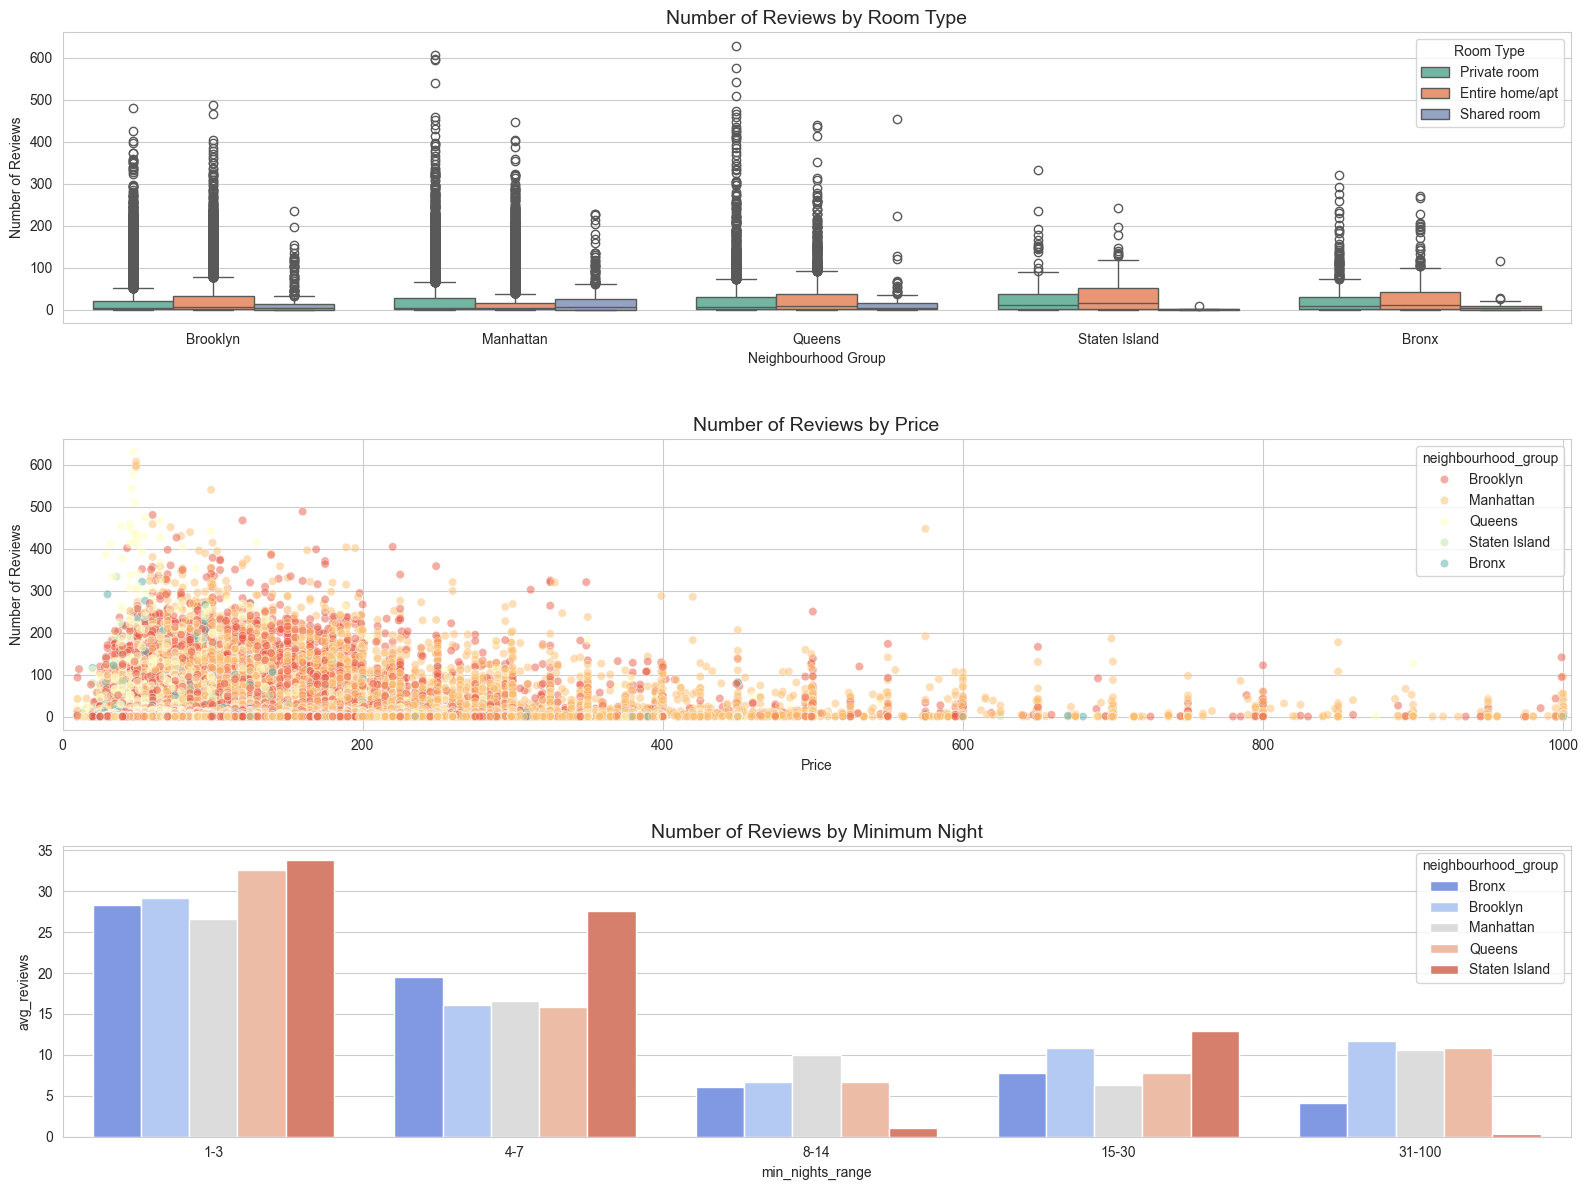

In [7]:
plt.figure(figsize=(16, 12))

# 1) room type
plt.subplot(3, 1, 1)
sns.boxplot(data=data, x="neighbourhood_group", y="number_of_reviews", hue="room_type", palette="Set2")
plt.title("Number of Reviews by Room Type", fontsize=14)
plt.xlabel("Neighbourhood Group")
plt.ylabel("Number of Reviews")
plt.legend(title="Room Type")

# 2) price
plt.subplot(3, 1, 2)
sns.scatterplot(data=data, x="price", y="number_of_reviews", hue="neighbourhood_group", alpha=0.5, palette="Spectral")
plt.title("Number of Reviews by Price", fontsize=14)
plt.xlabel("Price")
plt.ylabel("Number of Reviews")
plt.xlim(0, 1005)

# 3) minimum stay
# divided the minimum number of stay days into five intervals
data['min_nights_range'] = pd.cut(data['minimum_nights'], bins=[0, 3, 7, 14, 30, 100], labels=["1-3", "4-7", "8-14", "15-30", "31-100"])

min_nights_reviews = data.groupby(['neighbourhood_group', 'min_nights_range']).agg(avg_reviews=('number_of_reviews', 'mean')).reset_index()
plt.subplot(3, 1, 3)
plt.title("Number of Reviews by Minimum Night", fontsize=14)
sns.barplot(data=min_nights_reviews, x="min_nights_range", y="avg_reviews", hue="neighbourhood_group", palette="coolwarm")

plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.show()
